モジュールインポート

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

データの読み込み

In [ ]:
df_test = pd.read_csv('/content/sample_data/test.csv')
df_train = pd.read_csv('/content/sample_data/train.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
 14  curvature_squared   

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
 13  curvature_squared       172585 non-null  float64
 14  speed_curvature_rati

In [ ]:
print(df_train.columns.tolist())

['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']


### 特徴量エンジニアリング

In [ ]:
df_train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,...,school_season,num_reported_accidents,accident_risk,curvature_squared,speed_curvature_ratio,lanes_speed,accidents_per_lane,night_dark,holiday_night,school_season_night
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,...,True,1,0.13,0.0036,583.236127,70,0.333333,0,0,0
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,...,True,0,0.35,0.9801,35.353178,140,0.000000,0,0,0
2,2,rural,4,0.63,70,dim,clear,False,True,morning,...,False,2,0.30,0.3969,111.109347,280,0.400000,0,0,0
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,...,False,1,0.21,0.0049,499.928582,140,0.200000,0,0,0
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,...,False,1,0.56,0.3364,103.446492,60,0.500000,0,0,0


In [ ]:
# 1. 数値変換・組み合わせ
for df in [df_train, df_test]:
    df['curvature_squared'] = df['curvature'] ** 2
    df['speed_curvature_ratio'] = df['speed_limit'] / (df['curvature'] + 1e-5)
    df['lanes_speed'] = df['num_lanes'] * df['speed_limit']
    df['accidents_per_lane'] = df['num_reported_accidents'] / (df['num_lanes']+1)

# 3. 夜間かつ照明が悪い場所
for df in [df_train, df_test]:
    df['night_dark'] = ((df['time_of_day']=='evening') & (df['lighting']=='night')).astype(int)

# 4. 休日・学期・夜間の組み合わせ
for df in [df_train, df_test]:
    df['holiday_night'] = ((df['holiday']==1) & (df['lighting']=='night')).astype(int)
    df['school_season_night'] = ((df['school_season']==0) & (df['lighting']=='night')).astype(int)


### モデル作成：LGBM

In [ ]:
# 文字列型（object型）のカラムを取得
cat_cols = df_train.select_dtypes(include=["object"]).columns.tolist()

# LightGBM が扱えるように型を category に変換
for col in cat_cols:
    df_train[col] = df_train[col].astype("category")
    df_test[col] = df_test[col].astype("category")

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      517754 non-null  int64   
 1   road_type               517754 non-null  category
 2   num_lanes               517754 non-null  int64   
 3   curvature               517754 non-null  float64 
 4   speed_limit             517754 non-null  int64   
 5   lighting                517754 non-null  category
 6   weather                 517754 non-null  category
 7   road_signs_present      517754 non-null  bool    
 8   public_road             517754 non-null  bool    
 9   time_of_day             517754 non-null  category
 10  holiday                 517754 non-null  bool    
 11  school_season           517754 non-null  bool    
 12  num_reported_accidents  517754 non-null  int64   
 13  accident_risk           517754 non-null  float64 
 14  curv

In [ ]:
# 特徴量と目的変数を設定
target_col = "accident_risk"
exclude_cols = [target_col, "id"]
feature_cols = [c for c in df_train.columns if c not in exclude_cols]

X = df_train[feature_cols]
y = df_train[target_col]

In [ ]:
# --- fold ごとのモデルを保存するリスト ---
models = []

# クロスバリデーションの設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = []
oof_y = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"=== Fold {fold + 1} ===")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42
    )

    # コールバックで early stopping を指定
    callbacks = [
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)  # 100イテごとにログ出力
    ]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature="auto",  # カテゴリ列は自動認識
        callbacks=callbacks
    )

    # foldごとのモデルを保存
    models.append(model)

    preds = model.predict(X_valid, num_iteration=model.best_iteration_)
    oof_preds.extend(preds)
    oof_y.extend(y_valid)

=== Fold 1 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 19
[LightGBM] [Info] Start training from score 0.352605
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.00319843
[200]	valid_0's l2: 0.00317498
[300]	valid_0's l2: 0.00317006
[400]	valid_0's l2: 0.00316713
[500]	valid_0's l2: 0.00316578
[600]	valid_0's l2: 0.00316524
[700]	valid_0's l2: 0.00316498
Early stopping, best iteration is:
[652]	valid_0's l2: 0.00316485
=== Fold 2 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number 

In [ ]:
rmse = np.sqrt(mean_squared_error(oof_y, oof_preds))
print(f"CV RMSE: {rmse:.5f}")

CV RMSE: 0.05611


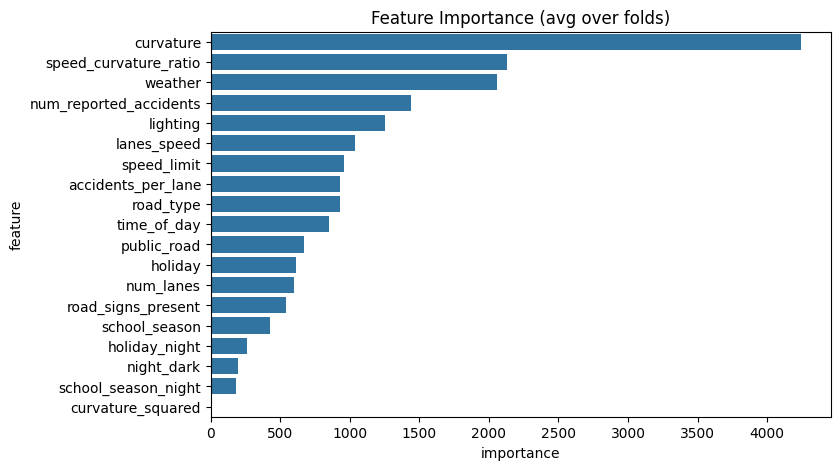

In [ ]:
# --- 特徴量重要度（foldごとの平均） ---
feature_importance = pd.DataFrame()

for i, model in enumerate(models):
    fi = pd.DataFrame({
        "feature": feature_cols,
        "importance": model.feature_importances_,
        "fold": i
    })
    feature_importance = pd.concat([feature_importance, fi], axis=0)

# foldごとに平均した重要度でソートして表示
plt.figure(figsize=(8,5))
sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance.groupby("feature")["importance"].mean().reset_index()
    .sort_values(by="importance", ascending=False)
)
plt.title("Feature Importance (avg over folds)")
plt.show()

テスト

In [ ]:
# ---- test データ予測（各foldモデルの平均） ----
X_test = df_test[feature_cols]
y_pred_test = np.mean([model.predict(X_test) for model in models], axis=0)

df_output = pd.DataFrame({
    "id": df_test["id"],
    "accident_risk": y_pred_test
})
df_output.to_csv("prar_vol4.csv", index=False)
print("prar_vol4.csv に予測値を出力しました")


prar_vol4.csv に予測値を出力しました
